In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [16]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [17]:
url = r"C:\\Users\\noa12\\OneDrive\\מסמכים\\GitHub\\Dogs_Vs_Cats_Project\\train\\"

In [18]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((55,55)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [19]:
data = create_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:04<00:00, 82.16it/s]


In [20]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [21]:
X = np.array([i[0] for i in data])
Y = np.array([i[1] for i in data])

In [22]:
X = X /255.0

In [23]:
X.shape

(25000, 55, 55)

In [24]:
X = X.reshape((25000, 55*55))
X.shape

(25000, 3025)

In [25]:
from sklearn.model_selection import train_test_split

#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [26]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42)

In [27]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),3))

The DummyClassifier score is: 0.503


## Models : 


### Feature selection: 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost import XGBClassifier

scores = [] 
for i in range(2000,3000,150):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train, test_size=0.1, random_state=42)
    XGB = XGBClassifier(objective="binary:logistic", random_state=42)
    XGB.fit(X_train_new, y_train_new, eval_metric='auc')
    y_predict = XGB.predict(X_val_new)
    accuracy = round(metrics.accuracy_score(y_val_new, y_predict),3)
    print("number of features : ", i, ", Accuracy:", accuracy)
    scores.append(accuracy)

>The best score of the model was with 2150 feature - We will use this number of features for the other models as well.

X_new = SelectKBest(chi2, k=2150).fit_transform(X_train, y_train)

X_train.shape

#### RandomForestClassifier :

In [51]:
%%time

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_pred_RF,y_val),3)
print("Accuracy:", accuracy)

Accuracy: 0.642
CPU times: total: 1min 32s
Wall time: 1min 33s


In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
RForest = RandomForestClassifier(random_state=42)
random_forest= cross_val_score(RForest, X_new,y_train, cv=kf, scoring='accuracy').mean()
print(round(random_forest,3))

0.636
CPU times: total: 2min 59s
Wall time: 3min


##### XGBClassifier:

In [ ]:
%%time

from xgboost import XGBClassifier

XGBoost = XGBClassifier(objective="binary:logistic", random_state=42)
XGBoost.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGBoost.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB))
print("Accuracy:", accuracy)

[0.00055 0.00029 0.00014 ... 0.00073 0.00117 0.00118]


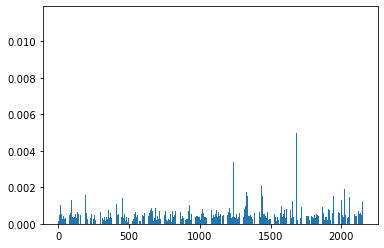

In [41]:
from matplotlib import pyplot
print(XGB.feature_importances_)
# plot
pyplot.bar(range(len(XGB.feature_importances_)), XGB.feature_importances_)
pyplot.show()

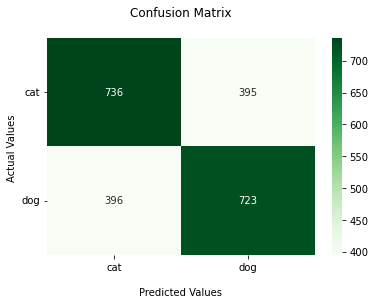

In [42]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

In [43]:
%%time
from xgboost import XGBClassifier

kf= KFold(n_splits=5, random_state=42, shuffle=True)
XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,eval_metric='auc')
XGB = cross_val_score(XGBClassifier, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(XGB)

KeyboardInterrupt: 

#### AdaBoostClassifier

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier

AdB = AdaBoostClassifier()
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
AdaBoost = AdaBoostClassifier()
AdB = cross_val_score(AdaBoost, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(AdB)


### GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))    

### Hyperparameter Tuning: 

In [ ]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#XGBClassifier
from xgboost import XGBClassifier
parameters = {
        'learning_rate': [ 0.1,0.3,0.03],
        'max_depth': [5,6,10],
        'min_child_weight': [1, 2],
        'subsample': [0.5,0.6,1],
        'colsample_bytree': [0.3,0.5, 0.7],
        'n_estimators' : [100,150,170,200]
         }

random_XGB = RandomizedSearchCV(XGBClassifier(),parameters, verbose=True, 
                          cv=3,random_state=42, return_train_score=True)
random_XGB.fit(X_train,y_train, eval_metric='auc')
y_pred_XGB_random = random_XGB.predict(X_val)
print ("Accuracy Score = ",round(metrics.accuracy_score(y_val,y_pred_XGB_random),3))
print (random_XGB.best_params_)

In [ ]:
random_XGB.best_params_